In [1]:
import datetime
import polars as pl
from load_data import PricesMonthly
from load_data import EnergyDataClient
from load_data import split_request_params_all_versions
from collections.abc import Sequence
from load_data import Elspotprices
from load_data import MAX_WORKERS
from load_data import _SPOT_FEE_DKK
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
start = datetime.date(2020, 1, 1)
end = datetime.date(2025, 12, 4)

In [3]:
client = EnergyDataClient()

In [4]:
seq_params = split_request_params_all_versions(start, end)
prices: Sequence[Elspotprices] = client.get(
    seq_parameters=seq_params, n_jobs=MAX_WORKERS
)

prices_df: pl.DataFrame = (
    pl.DataFrame(prices)
    .group_by(pl.col("HourUTC").dt.truncate("1h"), maintain_order=True)
    .agg(pl.col("SpotPriceDKK").mean().alias("SpotPriceDKK"))
    .with_columns(price_kwh_in_dkk=pl.col("SpotPriceDKK") / 1000 + _SPOT_FEE_DKK)
)


In [5]:

prices_monthly_df: pl.DataFrame = pl.DataFrame(
    [
        PricesMonthly(
            year=2023,
            month=6,
            monthly_price_kwh_in_dkk=96.52,
        ),
        PricesMonthly(
            year=2023,
            month=7,
            monthly_price_kwh_in_dkk=110.55,
        ),
        PricesMonthly(
            year=2023,
            month=8,
            monthly_price_kwh_in_dkk=100.83,
        ),
        PricesMonthly(
            year=2023,
            month=9,
            monthly_price_kwh_in_dkk=108.62,
        ),
        PricesMonthly(
            year=2023,
            month=10,
            monthly_price_kwh_in_dkk=98.80,
        ),
        PricesMonthly(
            year=2023,
            month=11,
            monthly_price_kwh_in_dkk=112.17,
        ),
        PricesMonthly(
            year=2023,
            month=12,
            monthly_price_kwh_in_dkk=108.81,
        ),
        PricesMonthly(
            year=2024,
            month=1,
            monthly_price_kwh_in_dkk=105.91,
        ),
        PricesMonthly(
            year=2024,
            month=2,
            monthly_price_kwh_in_dkk=91.65,
        ),
        PricesMonthly(
            year=2024,
            month=3,
            monthly_price_kwh_in_dkk=76.01,
        ),
        PricesMonthly(
            year=2024,
            month=4,
            monthly_price_kwh_in_dkk=67.39,
        ),
        PricesMonthly(
            year=2024,
            month=5,
            monthly_price_kwh_in_dkk=70.84,
        ),
        PricesMonthly(
            year=2024,
            month=6,
            monthly_price_kwh_in_dkk=78.67,
        ),
        PricesMonthly(
            year=2024,
            month=7,
            monthly_price_kwh_in_dkk=82.04,
        ),
        PricesMonthly(
            year=2024,
            month=8,
            monthly_price_kwh_in_dkk=80.63,
        ),
        PricesMonthly(
            year=2024,
            month=9,
            monthly_price_kwh_in_dkk=94.69,
        ),
        PricesMonthly(
            year=2024,
            month=10,
            monthly_price_kwh_in_dkk=81.68,
        ),
        PricesMonthly(
            year=2024,
            month=11,
            monthly_price_kwh_in_dkk=98.99,
        ),
        PricesMonthly(
            year=2024,
            month=12,
            monthly_price_kwh_in_dkk=111.03,
        ),
        PricesMonthly(
            year=2025,
            month=1,
            monthly_price_kwh_in_dkk=111.91,
        ),
        PricesMonthly(
            year=2025,
            month=2,
            monthly_price_kwh_in_dkk=92.95,
        ),
        PricesMonthly(
            year=2025,
            month=3,
            monthly_price_kwh_in_dkk=99.29,
        ),
        PricesMonthly(
            year=2025,
            month=4,
            monthly_price_kwh_in_dkk=86.11,
        ),
        PricesMonthly(
            year=2025,
            month=5,
            monthly_price_kwh_in_dkk=72.94,
        ),
        PricesMonthly(
            year=2025,
            month=6,
            monthly_price_kwh_in_dkk=85.06,
        ),
        PricesMonthly(
            year=2025,
            month=7,
            monthly_price_kwh_in_dkk=87.68,
        ),
        PricesMonthly(
            year=2025,
            month=8,
            monthly_price_kwh_in_dkk=88.87,
        ),
        PricesMonthly(
            year=2025,
            month=9,
            monthly_price_kwh_in_dkk=90.54,
        ),
        PricesMonthly(
            year=2025,
            month=10,
            monthly_price_kwh_in_dkk=97.11,
        ),
        PricesMonthly(
            year=2025,
            month=11,
            monthly_price_kwh_in_dkk=114.31,
        ),
        PricesMonthly(
            year=2025,
            month=12,
            monthly_price_kwh_in_dkk=116.08,
        ),
    ]
).with_columns(pl.col("monthly_price_kwh_in_dkk") / 100)

prices_monthly_ts = (
    pl.DataFrame()
    .with_columns(pl.date_range(start=start, end=end, interval="1d").alias("timestamp"))
    .with_columns(
        year=pl.col("timestamp").dt.year(),
        month=pl.col("timestamp").dt.month(),
    )
    .join(other=prices_monthly_df, on=["year", "month"], how="inner")
)

# Load consumption data
consumption_df: pl.DataFrame = pl.read_csv(
    source="/Users/wiz/projects/predictive-modeling/data/energi-data.csv",
    decimal_comma=True,
    schema={
        "HourUTC": pl.Datetime,
        "SpotPriceDKK": pl.Float64,
    },
).rename({"SpotPriceDKK": "consumption_kwh_hourly"})


# Joined

In [46]:
joined_df = (
    prices_df.drop("SpotPriceDKK")
    .join(other=consumption_df, on="HourUTC", how="left")
    .with_columns(
        pl.col("HourUTC")
        .dt.convert_time_zone("Europe/Copenhagen")
        .alias("timestamp")
    )
    # .filter(pl.col("timestamp").dt.year() >= 2024)
    .with_columns(pl.col("timestamp").dt.hour().alias("hour_of_day"))
    .with_columns(pl.col("timestamp").dt.day().alias("day_of_month"))
    .with_columns(pl.col("timestamp").dt.month().alias("month"))
    .with_columns(pl.col("timestamp").dt.year().alias("year"))
    .with_columns(pl.col("timestamp").dt.weekday().alias("weekday"))
    .with_columns(
        event_of_day=pl.when(pl.col("hour_of_day").is_between(6, 10, closed="left"))
        .then(pl.lit("Morning"))  # 0
        .when(pl.col("hour_of_day").is_between(10, 18, closed="left"))
        .then(pl.lit("Afternoon"))  # 1
        .when(pl.col("hour_of_day").is_between(18, 22, closed="left"))
        .then(pl.lit("Evening"))  # 2
        .when(
            pl.col("hour_of_day").is_between(22, 24, closed="both")
            | pl.col("hour_of_day").is_between(0, 6, closed="left")
        )
        .then(pl.lit("Night"))  # 3
        .otherwise(-99)
    )
    .join(other=prices_monthly_df, on=["year", "month"], how="left")
    .with_columns(
        consumption_in_dkk=pl.col("price_kwh_in_dkk")
        * pl.col("consumption_kwh_hourly")
    )
    .with_columns(
        consumption_in_dkk_status_quo=pl.col("monthly_price_kwh_in_dkk")
        * pl.col("consumption_kwh_hourly")
    )
)

<Axes: xlabel='timestamp', ylabel='price_kwh_in_dkk_sum'>

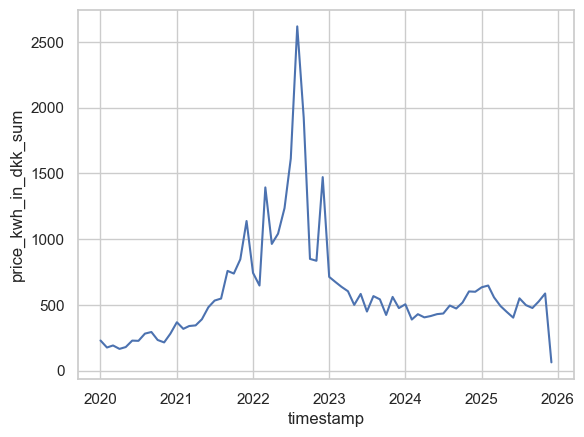

In [47]:
df = (
    joined_df
    .group_by(pl.col("timestamp").dt.truncate("1mo"), maintain_order=True)
    .agg(pl.col("price_kwh_in_dkk").sum().alias("price_kwh_in_dkk_sum"))
)
sns.lineplot(data=df, x="timestamp", y="price_kwh_in_dkk_sum")

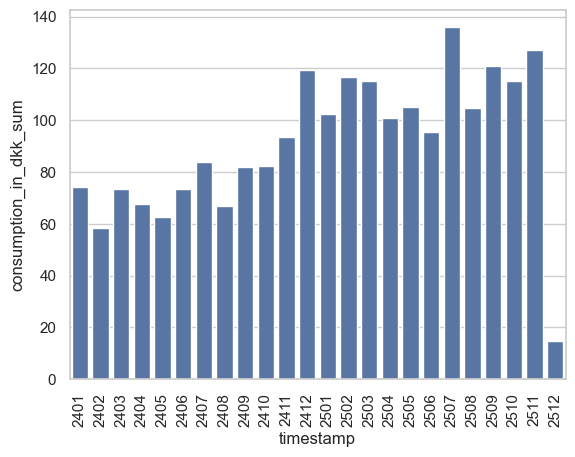

In [52]:
sns.set_theme(style="whitegrid")
df = (
    joined_df.filter(pl.col("timestamp").dt.year() >= 2024)
    .group_by(pl.col("timestamp").dt.truncate("1mo"), maintain_order=True)
    .agg(pl.col("consumption_in_dkk").sum().alias("consumption_in_dkk_sum"))
)
sns.barplot(data=df, x="timestamp", y="consumption_in_dkk_sum")
plt.xticks(
    ticks=range(len(df)),
    labels=df["timestamp"].dt.strftime("%y%m").cast(pl.Int64()).to_list(),
    rotation=90,
    ha='center'
);  # 45 degrees, aligned right


# What if analysis

In [48]:
what_if_df = (
    prices_df.drop("SpotPriceDKK")
    .join(other=consumption_df.with_columns(pl.col("HourUTC").dt.offset_by("-2y")), on="HourUTC", how="left")
    .with_columns(
        pl.col("HourUTC")
        .dt.convert_time_zone("Europe/Copenhagen")
        .alias("timestamp")
    )
    # .filter(pl.col("timestamp").dt.year() >= 2024)
    .with_columns(pl.col("timestamp").dt.hour().alias("hour_of_day"))
    .with_columns(pl.col("timestamp").dt.day().alias("day_of_month"))
    .with_columns(pl.col("timestamp").dt.month().alias("month"))
    .with_columns(pl.col("timestamp").dt.year().alias("year"))
    .with_columns(pl.col("timestamp").dt.weekday().alias("weekday"))
    .with_columns(
        event_of_day=pl.when(pl.col("hour_of_day").is_between(6, 10, closed="left"))
        .then(pl.lit("Morning"))  # 0
        .when(pl.col("hour_of_day").is_between(10, 18, closed="left"))
        .then(pl.lit("Afternoon"))  # 1
        .when(pl.col("hour_of_day").is_between(18, 22, closed="left"))
        .then(pl.lit("Evening"))  # 2
        .when(
            pl.col("hour_of_day").is_between(22, 24, closed="both")
            | pl.col("hour_of_day").is_between(0, 6, closed="left")
        )
        .then(pl.lit("Night"))  # 3
        .otherwise(-99)
    )
    # .join(other=prices_monthly_df, on=["year", "month"], how="left")
    .with_columns(
        consumption_in_dkk=pl.col("price_kwh_in_dkk")
        * pl.col("consumption_kwh_hourly")
    )
    # .with_columns(
    #     consumption_in_dkk_status_quo=pl.col("monthly_price_kwh_in_dkk")
    #     * pl.col("consumption_kwh_hourly")
    # )
    .filter(pl.col("consumption_in_dkk").is_not_null())
    .sort("HourUTC")
    .with_columns(
      pl.col("consumption_in_dkk")
      .rolling_sum_by("HourUTC", window_size="1mo")
      .alias("consumption_in_dkk_rolling_sum")
)
)
what_if_df


HourUTC,price_kwh_in_dkk,consumption_kwh_hourly,timestamp,hour_of_day,day_of_month,month,year,weekday,event_of_day,consumption_in_dkk,consumption_in_dkk_rolling_sum
datetime[μs],f64,f64,"datetime[μs, Europe/Copenhagen]",i8,i8,i8,i32,i8,str,f64,f64
2021-12-01 00:00:00,0.91573,0.05,2021-12-01 01:00:00 CET,1,1,12,2021,3,"""Night""",0.045786,0.045786
2021-12-01 01:00:00,0.84426,0.05,2021-12-01 02:00:00 CET,2,1,12,2021,3,"""Night""",0.042213,0.087999
2021-12-01 02:00:00,0.81883,0.04,2021-12-01 03:00:00 CET,3,1,12,2021,3,"""Night""",0.032753,0.120753
2021-12-01 03:00:00,0.76595,0.05,2021-12-01 04:00:00 CET,4,1,12,2021,3,"""Night""",0.038298,0.15905
2021-12-01 04:00:00,0.82106,0.05,2021-12-01 05:00:00 CET,5,1,12,2021,3,"""Night""",0.041053,0.200103
…,…,…,…,…,…,…,…,…,…,…,…
2023-12-05 19:00:00,1.07903,0.37,2023-12-05 20:00:00 CET,20,5,12,2023,2,"""Evening""",0.399241,141.925074
2023-12-05 20:00:00,0.9985,0.14,2023-12-05 21:00:00 CET,21,5,12,2023,2,"""Evening""",0.13979,141.792342
2023-12-05 21:00:00,0.95168,0.19,2023-12-05 22:00:00 CET,22,5,12,2023,2,"""Night""",0.180819,141.913899


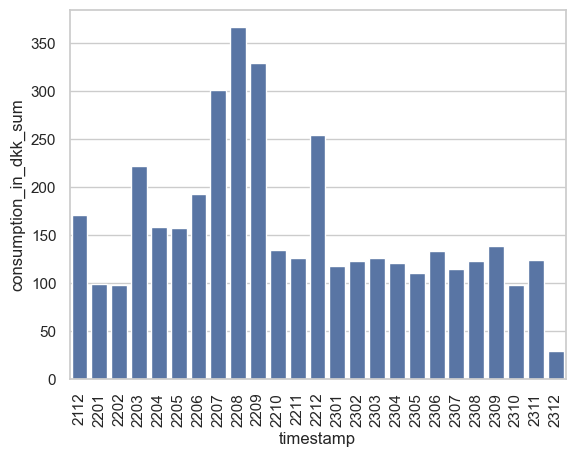

In [49]:
sns.set_theme(style="whitegrid")
df = (
    what_if_df
    .group_by(pl.col("timestamp").dt.truncate("1mo"), maintain_order=True)
    .agg(pl.col("consumption_in_dkk").sum().alias("consumption_in_dkk_sum"))
)
sns.barplot(data=df, x="timestamp", y="consumption_in_dkk_sum")
plt.xticks(
    ticks=range(len(df)),
    labels=df["timestamp"].dt.strftime("%y%m").cast(pl.Int64()).to_list(),
    rotation=90,
    ha='center'
);  # 45 degrees, aligned right


<Axes: xlabel='timestamp', ylabel='consumption_in_dkk_rolling_sum'>

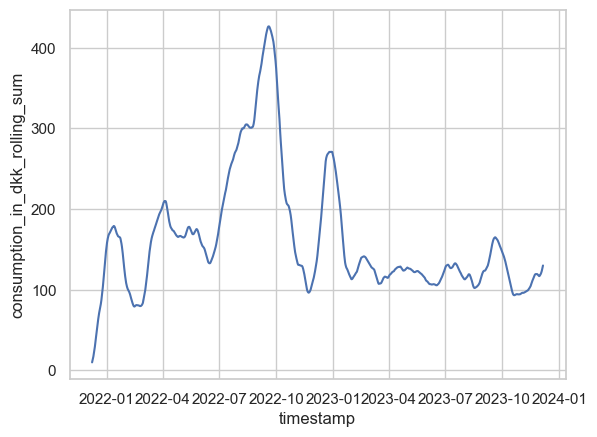

In [50]:
df = what_if_df.with_columns(pl.col("consumption_in_dkk_rolling_sum").rolling_mean(window_size=7 * 24))
sns.lineplot(data=df, x="timestamp", y="consumption_in_dkk_rolling_sum")
